In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wget

import seaborn
import numpy as np
import pandas as pd
import pylab
import sklearn.preprocessing

import scgenome

import dbclients.tantalus

import envsetup



# Load segment data


In [2]:

tantalus_api = dbclients.tantalus.TantalusApi()

client = tantalus_api.get_storage_client('singlecellblob_results')

def read_blob_csv(url, dest):
    if not os.path.exists(dest):
        print 'downloading ', url
        filename = wget.download(url)
        os.rename(filename, dest)

    return pd.read_csv(dest)

# SA922
url = client.get_url('SC-878/results/results/hmmcopy/A90554B_reads.csv')
dest = 'A90554B_reads.csv'
data_sa922 = read_blob_csv(url, dest)

# SA921
url = client.get_url('SC-877/results/results/hmmcopy/A90554A_reads.csv')
dest = 'A90554A_reads.csv'
data_sa921 = read_blob_csv(url, dest)

# SA1090
url = client.get_url('SC-795/results/results/hmmcopy/A96213A_reads.csv')
dest = 'A96213A_reads.csv'
data_sa1090 = read_blob_csv(url, dest)

data_sa922['sample_id'] = data_sa922['cell_id'].apply(lambda a: a.split('-')[0])
data_sa921['sample_id'] = data_sa921['cell_id'].apply(lambda a: a.split('-')[0])
data_sa1090['sample_id'] = data_sa1090['cell_id'].apply(lambda a: a.split('-')[0])

data_sa922['external_sample_id'] = 'OV2295(R2)'
data_sa921['external_sample_id'] = 'TOV2295(R)'
data_sa1090['external_sample_id'] = 'OV2295'


In [3]:

cn_data = pd.concat([data_sa922, data_sa921, data_sa1090], ignore_index=True)

cn_data = cn_data[cn_data['sample_id'].isin(['SA922', 'SA921', 'SA1090'])]

cn_data['integer_copy_number'] = cn_data['state']



# Load metrics data


1966


,cell_id,unpaired_mapped_reads,paired_mapped_reads,unpaired_duplicate_reads,paired_duplicate_reads,unmapped_reads,percent_duplicate_reads,estimated_library_size,total_reads,total_mapped_reads,...,mad_neutral_state,breakpoints,mean_copy,state_mode,loglikehood,true_multiplier,too_even,jira_id,quality,sample_id
0,SA922-A90554B-R23-C03,393,604,0,3,338829,0.003748,60601.0,340430,1601,...,0.021077,61,2.261541,2,-611.204707,1.964997,False,SC-878,0.000,SA922
1,SA922-A90554B-R23-C05,398,1793,7,111,462902,0.057480,13877.0,466886,3984,...,0.000000,514,5.099099,4,1007.001969,4.000000,True,SC-878,0.000,SA922
2,SA922-A90554B-R23-C16,14787,761068,2692,73543,135428,0.097471,3680609.0,1672352,1536924,...,0.051489,131,4.275032,4,-5950.076400,4.961840,False,SC-878,0.658,SA922
3,SA922-A90554B-R23-C22,13409,699382,2227,61072,129954,0.088082,3768326.0,1542128,1412174,...,0.064229,105,3.967854,5,-5206.665804,4.096858,False,SC-878,0.662,SA922
4,SA922-A90554B-R23-C24,21658,1110243,4440,108243,205368,0.098549,5318193.0,2447512,2242144,...,0.029017,151,5.508476,6,-6172.309749,5.970744,False,SC-878,0.728,SA922


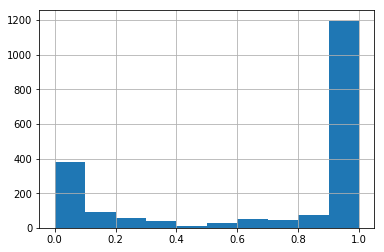

In [4]:

# SA922
url = client.get_url('SC-878/results/results/hmmcopy/A90554B_all_metrics_summary.csv')
dest = 'A90554B_metrics.csv'
metrics_sa922 = read_blob_csv(url, dest)

# SA921
url = client.get_url('SC-877/results/results/hmmcopy/A90554A_all_metrics_summary.csv')
dest = 'A90554A_metrics.csv'
metrics_sa921 = read_blob_csv(url, dest)

# SA1090
url = client.get_url('SC-795/results/results/hmmcopy/A96213A_all_metrics_summary.csv')
dest = 'A96213A_metrics.csv'
metrics_sa1090 = read_blob_csv(url, dest)

metrics_sa922['sample_id'] = metrics_sa922['cell_id'].apply(lambda a: a.split('-')[0])
metrics_sa921['sample_id'] = metrics_sa921['cell_id'].apply(lambda a: a.split('-')[0])
metrics_sa1090['sample_id'] = metrics_sa1090['cell_id'].apply(lambda a: a.split('-')[0])

data_sa922['external_sample_id'] = 'OV2295(R2)'
data_sa921['external_sample_id'] = 'TOV2295(R)'
data_sa1090['external_sample_id'] = 'OV2295'

metrics_data = pd.concat([metrics_sa922, metrics_sa921, metrics_sa1090])
metrics_data = metrics_data[metrics_data['sample_id'].isin(['SA922', 'SA921', 'SA1090'])]
metrics_data['quality'].hist()
print len(metrics_data['cell_id'].unique())
metrics_data.head()



# Filtering


1966
1542
1345


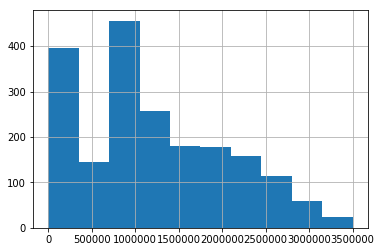

In [5]:

cn_data.groupby('cell_id')['reads'].sum().hist()

cell_read_counts = cn_data.groupby('cell_id')['reads'].sum().rename('total_reads')
cell_read_counts = cell_read_counts[cell_read_counts > 500000]

filtered_cell_ids = metrics_data[metrics_data['quality'] > 0.5][['cell_id']].drop_duplicates()

print len(cn_data['cell_id'].unique())
cn_data = cn_data.merge(cell_read_counts.reset_index())
print len(cn_data['cell_id'].unique())
cn_data = cn_data.merge(filtered_cell_ids.reset_index())
print len(cn_data['cell_id'].unique())


In [6]:

import scgenome.cncluster

cn = cn_data.set_index(['chr', 'start', 'cell_id'])['integer_copy_number'].unstack(level=2).fillna(0)

cluster_df = scgenome.cncluster.umap_hdbscan_cluster(cn)

if 'cluster_id' in cn_data:
    cn_data.drop('cluster_id', axis=1, inplace=True)

cn_data = cn_data.merge(cluster_df)

if 'clone_cn' in cn_data:
    cn_data.drop('clone_cn', axis=1, inplace=True)

clone_cn = (
    cn_data.groupby(['chr', 'start', 'cluster_id'])['integer_copy_number']
    .median().rename('clone_cn').reset_index())
cn_data = cn_data.merge(clone_cn)

cluster_df.groupby('cluster_id').size().rename('size').reset_index()


,cluster_id,size
0,-1,17
1,0,37
2,1,170
3,2,49
4,3,138
5,4,191
6,5,214
7,6,33
8,7,81
9,8,39


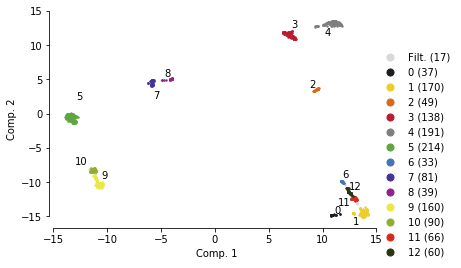

In [7]:

scgenome.cncluster.plot_umap_clusters(plt.gca(), cluster_df)


In [8]:

# cn_data2 = cn_data.copy()
# cn_data2['clone_var'] = np.square(cn_data2['integer_copy_number'] - cn_data2['clone_cn'])
# clone_std = cn_data2.groupby('cell_id')['clone_var'].sum().pow(1./2).rename('clone_std').reset_index()
# clone_rms = cn_data2.groupby('cell_id')['clone_var'].mean().pow(1./2).rename('clone_rms').reset_index()

# cluster_df = cluster_df.merge(clone_std)
# cluster_df = cluster_df.merge(clone_rms)

# cluster_df['clone_std'] = cluster_df['clone_std']#.clip_upper(75.)

# fig = plt.figure(figsize=(8, 8))
# plt.scatter(
#     cluster_df['umap1'].values,
#     cluster_df['umap2'].values,
#     c=cluster_df['clone_std'].values,
#     cmap=plt.get_cmap("Reds"),
#     s=2)

# fig = plt.figure()
# cluster_df['clone_std'].hist(bins=30)

# print len(cluster_df['cell_id'].unique())
# cluster_df = cluster_df[cluster_df['clone_std'] < 60.]
# print len(cluster_df['cell_id'].unique())
# clone_counts = cluster_df.groupby('cluster_id')['cell_id'].count()
# print clone_counts
# clone_counts_filter = clone_counts[clone_counts >= 50].reset_index()
# cluster_df = cluster_df.merge(clone_counts_filter[['cluster_id']])
# print len(cluster_df['cell_id'].unique())
# print cluster_df.groupby('cluster_id')['cell_id'].count().describe()

# cluster_df['is_filtered'] = cluster_df['clone_std'] < 60.
# seaborn.factorplot(data=cluster_df, x='is_filtered', y='clone_std', kind='strip', jitter=True)
# seaborn.factorplot(data=cluster_df, x='is_filtered', y='clone_rms', kind='strip', jitter=True)

# cn_data_filtered = cn_data[cn_data['cell_id'].isin(cluster_df['cell_id'].unique())]

# cluster_df.groupby('is_filtered')['clone_std'].describe()
# cluster_df.groupby('is_filtered')['clone_rms'].describe()

# cluster_df = pd.read_csv('ov2295_umap_clusters.tsv', sep='\t').rename(columns={'gm_umap_cluster': 'cluster_id'})

cn_data_filtered = cn_data.drop('cluster_id', axis=1).merge(cluster_df)
cn_data_filtered = cn_data_filtered.query('cluster_id >= 0')

# cn_data_filtered.head()


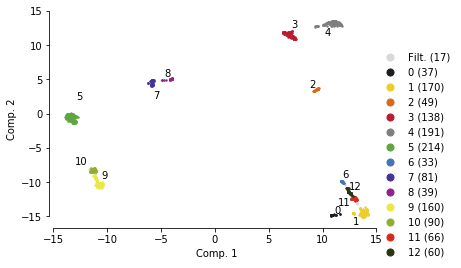

In [9]:

scgenome.cncluster.plot_umap_clusters(plt.gca(), cluster_df)


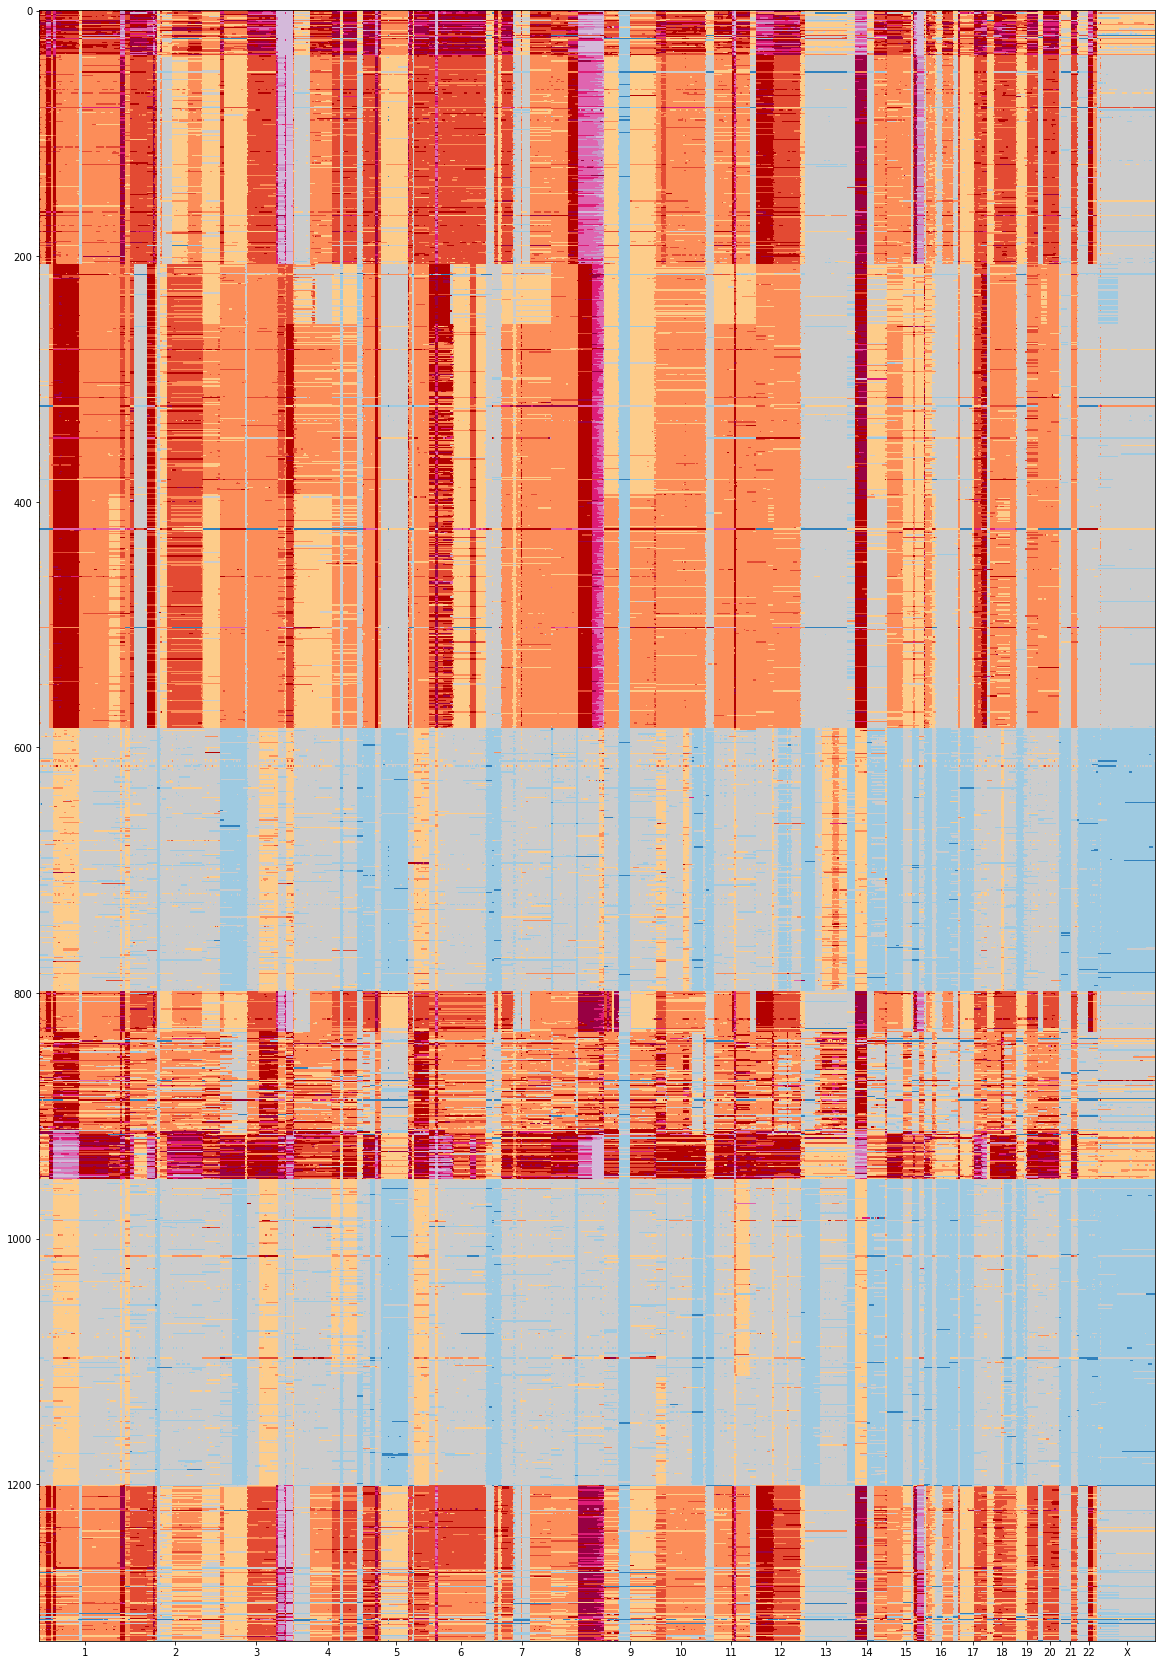

In [10]:

import scgenome.cnplot

fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(111)
scgenome.cnplot.plot_clustered_cell_cn_matrix(ax, cn_data_filtered, 'integer_copy_number')


In [11]:

cn_data.head()


,chr,start,end,width,reads,gc,map,cor_gc,copy,valid,...,cell_id,sample_id,external_sample_id,integer_copy_number,total_reads,index,cluster_id,umap1,umap2,clone_cn
0,1,1,500000,500000,3,-1.0,0.348523,NaN,NaN,False,...,SA922-A90554B-R23-C16,SA922,OV2295(R2),4,1304471,2,1,13.618648,-14.297989,5.0
1,1,1,500000,500000,12,-1.0,0.348523,NaN,NaN,False,...,SA922-A90554B-R23-C22,SA922,OV2295(R2),5,1209382,3,1,13.718306,-14.276929,5.0
2,1,1,500000,500000,15,-1.0,0.348523,NaN,NaN,False,...,SA922-A90554B-R23-C26,SA922,OV2295(R2),6,2611129,5,1,14.086307,-14.569838,5.0
3,1,1,500000,500000,11,-1.0,0.348523,NaN,NaN,False,...,SA922-A90554B-R23-C30,SA922,OV2295(R2),5,2717667,9,1,13.853062,-15.117743,5.0
4,1,1,500000,500000,6,-1.0,0.348523,NaN,NaN,False,...,SA922-A90554B-R23-C33,SA922,OV2295(R2),4,986260,12,1,14.028734,-13.854144,5.0


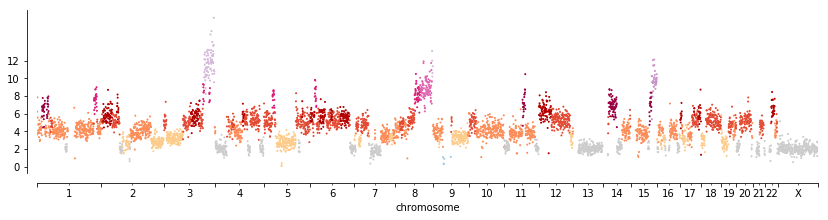

In [12]:

import matplotlib

fig = plt.figure(figsize=(14, 3))
ax = fig.add_subplot(111)
scgenome.cnplot.plot_cell_cn_profile(
    ax, cn_data_filtered.query('cell_id == "SA922-A90554B-R23-C16"'), 'copy', 'integer_copy_number')


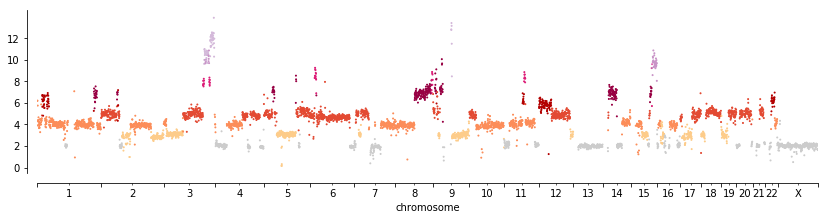

In [13]:

clone_cn_state = (
    cn_data_filtered.groupby(['chr', 'start', 'end', 'cluster_id'])['integer_copy_number']
    .median().astype(int).reset_index())

clone_cn_copy = (
    cn_data_filtered.groupby(['chr', 'start', 'end', 'cluster_id'])['copy']
    .mean().reset_index())

clone_cn_data = clone_cn_state.merge(clone_cn_copy)

clone_cn_data.to_csv('ov2295_clone_cn.csv', index=False)

fig = plt.figure(figsize=(14, 3))
ax = fig.add_subplot(111)
scgenome.cnplot.plot_cell_cn_profile(
    ax, clone_cn_data.query('cluster_id == 6'), 'copy', 'integer_copy_number')


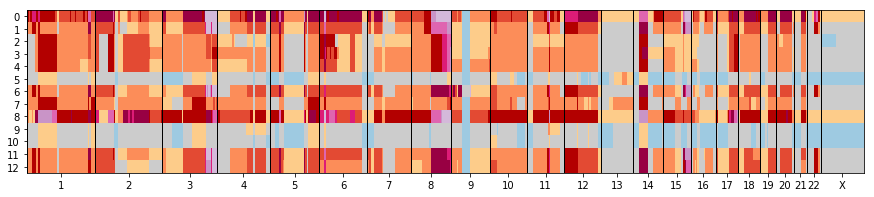

In [14]:

import scgenome.cnplot

fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot(111)
scgenome.cnplot.plot_cluster_cn_matrix(ax, cn_data_filtered, 'integer_copy_number')



# Cell specific haplotype block allele counts


In [15]:

data_dir = "."

sa921_allele_counts = pd.read_csv(os.path.join(data_dir, 'SA921_allele_counts.csv'))
sa922_allele_counts = pd.read_csv(os.path.join(data_dir, 'SA922_allele_counts.csv'))
sa1090_allele_counts = pd.read_csv(os.path.join(data_dir, 'SA1090_allele_counts.csv'))

allele_counts = pd.concat([
    sa921_allele_counts,
    sa922_allele_counts,
    sa1090_allele_counts,
], ignore_index=True)

allele_counts.head()


,allele_id,cell_id,chromosome,end,hap_label,readcount,start
0,0,SA921-A90554A-R12-C09,1,7000000,420,1,6500000
1,1,SA921-A90554A-R12-C09,1,43500000,1799,1,43000000
2,0,SA921-A90554A-R12-C09,1,44000000,1817,1,43500000
3,0,SA921-A90554A-R12-C09,1,51500000,2023,1,51000000
4,1,SA921-A90554A-R12-C09,1,61000000,2292,1,60500000


In [16]:

index_cols = [
    'chromosome',
    'start',
    'end',
    'hap_label',
]

bin_size = 500000

allele_counts = allele_counts.set_index(index_cols + ['cell_id', 'allele_id'])['readcount'].unstack(fill_value=0)
allele_counts.rename(columns={0: 'allele_1', 1: 'allele_2'}, inplace=True)
allele_counts.reset_index(inplace=True)
allele_counts = allele_counts.merge(cluster_df)
allele_counts = allele_counts.groupby(index_cols + ['cluster_id'])[['allele_1', 'allele_2']].sum().reset_index()
allele_counts['total'] = allele_counts['allele_1'] + allele_counts['allele_2']
allele_counts['start'] = (allele_counts['start'] / bin_size).astype(int) * bin_size + 1
allele_counts['end'] = allele_counts['start'] + bin_size - 1
allele_counts.head()


,chromosome,start,end,hap_label,cluster_id,allele_1,allele_2,total
0,1,1,500000,0,-1,3,1,4
1,1,1,500000,0,0,0,1,1
2,1,1,500000,0,1,4,6,10
3,1,1,500000,0,2,0,4,4
4,1,1,500000,0,3,4,4,8


In [17]:

allele_counts.query('cluster_id == 6').head(10)


,chromosome,start,end,hap_label,cluster_id,allele_1,allele_2,total
7,1,1,500000,0,6,1,4,5
33,1,1,500000,3,6,0,1,1
60,1,500001,1000000,6,6,2,1,3
72,1,500001,1000000,7,6,1,1,2
84,1,500001,1000000,8,6,3,1,4
108,1,500001,1000000,10,6,2,0,2
119,1,500001,1000000,11,6,3,2,5
131,1,500001,1000000,12,6,0,1,1
143,1,500001,1000000,15,6,1,0,1
161,1,500001,1000000,17,6,1,0,1


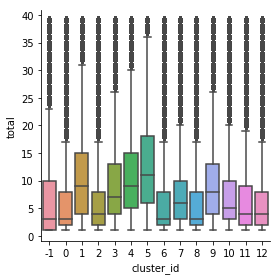

In [18]:

plot_data = allele_counts.query('total < 40')
seaborn.factorplot(x='cluster_id', y='total', kind='box', data=plot_data)



## Infer allele specific CN


In [19]:

import scgenome.snpdata

data = allele_counts.rename(columns={
    'chromosome': 'chr',
    'total': 'total_counts_sum',
    'allele_1': 'allele_1_sum',
    'allele_2': 'allele_2_sum',
})

hap_data = data.copy()

hap_data = hap_data[hap_data['total_counts_sum'] > 5].copy()

hap_data['maf'] = (
    np.minimum(hap_data['allele_1_sum'], hap_data['allele_2_sum']) /
    hap_data['total_counts_sum'].astype(float))

allele_cn = scgenome.snpdata.infer_allele_cn(clone_cn_data, data)

allele_cn['maf'] = (
    np.minimum(allele_cn['allele_1_sum'], allele_cn['allele_2_sum']) /
    allele_cn['total_counts_sum'].astype(float))

allele_cn.query('chr == "4"').query('total_counts_sum > 100').head()


/home/ubuntu/notebooks/pseudo_wgs/scgenome/scgenome/snpdata.py:114: RuntimeWarning: divide by zero encountered in divide
  p = minor_cn / cn['total_cn'].values[:, np.newaxis]
/home/ubuntu/notebooks/pseudo_wgs/scgenome/scgenome/snpdata.py:114: RuntimeWarning: invalid value encountered in divide
  p = minor_cn / cn['total_cn'].values[:, np.newaxis]
/anaconda/envs/py27/lib/python2.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/anaconda/envs/py27/lib/python2.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in less_equal
  return (n >= 0) & (p >= 0) & (p <= 1)


,chr,start,end,cluster_id,total_cn,copy,hap_label,allele_1_sum,allele_2_sum,total_counts_sum,minor_cn,major_cn,maf
824955,4,1,500000,0,6.0,0.0,2.0,82.0,100.0,182.0,2,4.0,0.450549
824965,4,1,500000,0,6.0,0.0,13.0,134.0,151.0,285.0,2,4.0,0.470175
824967,4,1,500000,0,6.0,0.0,15.0,58.0,49.0,107.0,2,4.0,0.457944
824974,4,1,500000,1,4.0,0.0,2.0,420.0,379.0,799.0,1,3.0,0.474343
824985,4,1,500000,1,4.0,0.0,13.0,629.0,741.0,1370.0,1,3.0,0.459124



## Allele plot for clone 1


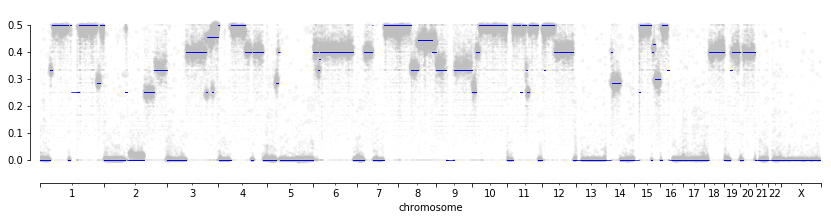

In [20]:

plot_cluster_id = 1

hap_data['maf'] = (
    np.minimum(hap_data['allele_1_sum'], hap_data['allele_2_sum']) /
    hap_data['total_counts_sum'].astype(float))

fig = plt.figure(figsize=(14, 3))
ax = fig.add_subplot(111)
scgenome.snpdata.plot_cell_vaf_profile(
    ax, hap_data.query('cluster_id == {}'.format(plot_cluster_id)), 'maf',
    size_field_name='total_counts_sum',
    size_scale=100.,
)   

allele_cn['cn_ratio'] = allele_cn['minor_cn'] / allele_cn['total_cn']

import scgenome.refgenome as refgenome
from matplotlib import collections  as mc

plot_data = allele_cn.query('cluster_id == {}'.format(plot_cluster_id)).copy()
plot_data = plot_data[plot_data['chr'].isin(refgenome.info.chromosomes)]

plot_data.set_index('chr', inplace=True)
plot_data['chromosome_start'] = refgenome.info.chromosome_start
plot_data.reset_index(inplace=True)

plot_data['start'] = plot_data['start'] + plot_data['chromosome_start']
plot_data['end'] = plot_data['end'] + plot_data['chromosome_start']

lines = np.zeros((plot_data.shape[0], 2, 2))
lines[:, 0, 0] = plot_data['start'].values
lines[:, 1, 0] = plot_data['end'].values
lines[:, 0, 1] = plot_data['cn_ratio'].values
lines[:, 1, 1] = plot_data['cn_ratio'].values

lc = mc.LineCollection(lines, colors='b', linewidths=1.)
ax.add_collection(lc)



In [21]:

allele_cn = scgenome.snpdata.infer_allele_cn(clone_cn_data, hap_data)
allele_cn.head()


,chr,start,end,cluster_id,total_cn,copy,hap_label,allele_1_sum,allele_2_sum,total_counts_sum,maf,minor_cn,major_cn
0,1,1,500000,0,6.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,6.0
1,1,1,500000,1,5.0,0.0,0.0,4.0,6.0,10.0,0.400000,0,5.0
2,1,1,500000,1,5.0,0.0,2.0,6.0,1.0,7.0,0.142857,0,5.0
3,1,1,500000,2,3.0,0.0,4.0,8.0,1.0,9.0,0.111111,0,3.0
4,1,1,500000,3,3.0,0.0,0.0,4.0,4.0,8.0,0.500000,0,3.0


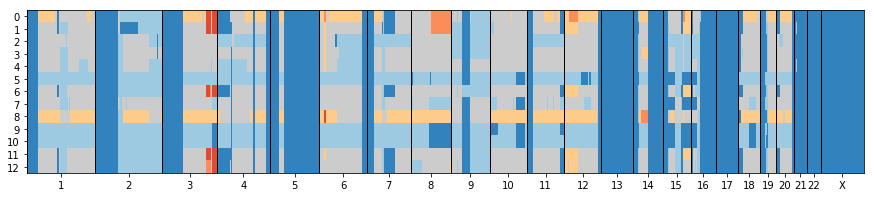

In [22]:

fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot(111)
scgenome.cnplot.plot_cluster_cn_matrix(ax, allele_cn, 'minor_cn')


In [23]:

snv_filenames = [
    'SA921_snv_annotations.h5',
    'SA922_snv_annotations.h5',
    'SA1090_snv_annotations.h5',
]

snv_filenames = [os.path.join(data_dir, filename) for filename in snv_filenames]


In [24]:

import scgenome.snvdata

snv_data = pd.concat([scgenome.snvdata.get_snv_results(filename) for filename in snv_filenames])

with pd.HDFStore('ov2295_snv_data.h5', 'w') as store:
    store['snv_data'] = snv_data

snv_data.head()


starting load
strelka (15214, 5)
museq (58724, 5)
finishing load (5682, 2)
starting load
strelka (16595, 5)
museq (61359, 5)
finishing load (6298, 2)
starting load
strelka (22751, 5)
museq (159387, 5)
finishing load (4975, 2)


/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['chrom', 'ref', 'alt', 'cell_id', 'is_cosmic', 'tri_nucleotide_context']]

  exec(code_obj, self.user_global_ns, self.user_ns)


,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,mappability,strelka_score,museq_score,is_cosmic,HIGH,LOW,MODERATE,MODIFIER,tri_nucleotide_context
0,8,145770028,G,C,0,1,SA921-A90554A-R03-C05,1.0,40,0.98,NaN,0,1,0,1,AGA
1,8,145770028,G,C,1,0,SA921-A90554A-R03-C28,1.0,40,0.98,NaN,0,1,0,1,AGA
2,8,145770028,G,C,1,0,SA921-A90554A-R03-C45,1.0,40,0.98,NaN,0,1,0,1,AGA
3,8,145770028,G,C,1,0,SA921-A90554A-R04-C08,1.0,40,0.98,NaN,0,1,0,1,AGA
4,8,145770028,G,C,1,0,SA921-A90554A-R04-C11,1.0,40,0.98,NaN,0,1,0,1,AGA


In [25]:

snv_counts_filenames = [
    'SA921_snv_counts.h5',
    'SA922_snv_counts.h5',
    'SA1090_snv_counts.h5',
]

snv_counts_filenames = [os.path.join(data_dir, filename) for filename in snv_counts_filenames]

snv_count_data = []

positions = snv_data[['chrom', 'coord', 'ref', 'alt']].drop_duplicates()

for filename in snv_counts_filenames:
    with pd.HDFStore(filename) as store:
        snv_count_data.append(store['/snv_allele_counts'].merge(positions, how='inner'))

snv_count_data = pd.concat(snv_count_data, ignore_index=True)


In [26]:

snv_data = snv_data.drop(['alt_counts', 'ref_counts'], axis=1)
snv_data = snv_data.merge(
    snv_count_data, how='outer',
    on=['chrom', 'coord', 'ref', 'alt', 'cell_id']).fillna(0)
snv_data['total_counts'] = snv_data['ref_counts'] + snv_data['alt_counts']
snv_data['sample_id'] = snv_data['cell_id'].apply(lambda a: a.split('-')[0])

assert not snv_data['coord'].isnull().any()
assert not snv_data['alt_counts'].isnull().any()

snv_data.head()


,chrom,coord,ref,alt,cell_id,mappability,strelka_score,museq_score,is_cosmic,HIGH,LOW,MODERATE,MODIFIER,tri_nucleotide_context,ref_counts,alt_counts,total_counts,sample_id
0,8,145770028,G,C,SA921-A90554A-R03-C05,1.0,40.0,0.98,0,0.0,1.0,0.0,1.0,AGA,0,1,1,SA921
1,8,145770028,G,C,SA921-A90554A-R03-C28,1.0,40.0,0.98,0,0.0,1.0,0.0,1.0,AGA,1,0,1,SA921
2,8,145770028,G,C,SA921-A90554A-R03-C45,1.0,40.0,0.98,0,0.0,1.0,0.0,1.0,AGA,1,0,1,SA921
3,8,145770028,G,C,SA921-A90554A-R04-C08,1.0,40.0,0.98,0,0.0,1.0,0.0,1.0,AGA,1,0,1,SA921
4,8,145770028,G,C,SA921-A90554A-R04-C11,1.0,40.0,0.98,0,0.0,1.0,0.0,1.0,AGA,1,0,1,SA921


In [27]:

if 'cluster_id' in snv_data:
    snv_data.drop(['cluster_id'], axis=1, inplace=True)
snv_data = snv_data.merge(cluster_df)


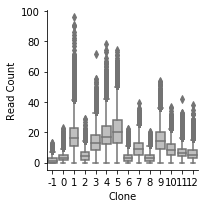

In [28]:

# Distribution of per variant total counts summed across clones

data2 = (
    snv_data.groupby(['chrom', 'coord', 'ref', 'alt', 'cluster_id'])[['total_counts', 'ref_counts', 'alt_counts']]
    .sum().unstack(fill_value=0).stack().reset_index())

plot_data = data2.rename(columns={
    'cluster_id': 'Clone',
    'total_counts': 'Read Count',
})

seaborn.factorplot(x='Clone', y='Read Count', kind='box', data=plot_data, color='0.75', size=3)


In [29]:

import sys
sys.setrecursionlimit(10000)

# min_total_counts_filter = min_total_counts[min_total_counts['total_counts'] >= 4]

sum_alt_counts = snv_data.groupby(['chrom', 'coord', 'ref', 'alt'])['alt_counts'].sum()
present_anywhere_filter = sum_alt_counts[sum_alt_counts > 0].reset_index().drop('alt_counts', axis=1)

data2 = snv_data.copy()
data2['sample_id'] = data2['cell_id'].apply(lambda a: a.split('-')[0])
data2 = data2.merge(cluster_df)
data2 = (
    data2.groupby(['chrom', 'coord', 'cluster_id'])[['alt_counts', 'ref_counts']]
    .sum().unstack(fill_value=0).stack().reset_index())
data2['total_counts'] = data2['ref_counts'] + data2['alt_counts']
data2['vaf'] = data2['alt_counts'] / data2['total_counts']
data2['alt_counts'] = data2['alt_counts'].clip_upper(10)
data2['is_present'] = (data2['alt_counts'] > 0) * 1
data2['is_absent'] = (data2['alt_counts'] == 0) * 1
data2['is_het'] = (data2['alt_counts'] < 0.99 * data2['total_counts']) * data2['is_present']
data2['is_hom'] = (data2['alt_counts'] >= 0.99 * data2['total_counts']) * data2['is_present']
data2['state'] = data2['is_hom'] * 3 + data2['is_het'] * 2 + data2['is_absent']
# data2 = data2[data2['total_counts'] > 0]
# data2 = data2.merge(min_total_counts_filter[['chrom', 'coord', 'ref', 'alt']])
data2 = data2.merge(present_anywhere_filter[['chrom', 'coord', 'ref', 'alt']])
data2 = data2.set_index(['chrom', 'coord', 'cluster_id'])['is_present'].unstack(fill_value=0)
print data2.shape


(12253, 14)


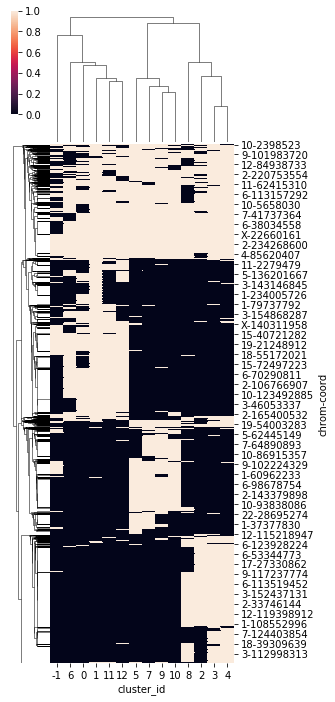

In [30]:

g = seaborn.clustermap(data2, rasterized=True, row_cluster=True, figsize=(4, 12))



# Breakpoints


In [31]:


def get_breakpoint_results(filename):
    store = pd.HDFStore(filename, 'r')

    print store['/breakpoint'].shape[0]

    data = store['/breakpoint']
    data = data.drop(['num_reads', 'num_unique_reads'], axis=1)
    data = data.merge(store['/breakpoint_library'], on='prediction_id')

    print data.shape[0]

    return data

breakpoint_filenames = [
    'SA921_destruct.h5',
    'SA922_destruct.h5',
    'SA1090_destruct.h5',
]

breakpoint_filenames = [os.path.join(data_dir, filename) for filename in breakpoint_filenames]

breakpoint_data = pd.concat([get_breakpoint_results(filename) for filename in breakpoint_filenames])
breakpoint_data.head()


190
1751
333
2659
1359
5122


,prediction_id,chromosome_1,strand_1,position_1,chromosome_2,strand_2,position_2,homology,num_split,inserted,...,num_patients,is_filtered,dist_filtered,balanced,rearrangement_type,num_reads,num_unique_reads,library,is_normal,patient_id
0,15,1,+,206261539,1,-,206260862,3,7,NaN,...,1,False,24967.0,False,duplication,1,1,SA921-A90554A-R08-C11,False,NaN
1,15,1,+,206261539,1,-,206260862,3,7,NaN,...,1,False,24967.0,False,duplication,1,1,SA921-A90554A-R15-C13,False,NaN
2,15,1,+,206261539,1,-,206260862,3,7,NaN,...,1,False,24967.0,False,duplication,1,1,SA921-A90554A-R04-C44,False,NaN
3,15,1,+,206261539,1,-,206260862,3,7,NaN,...,1,False,24967.0,False,duplication,1,1,SA921-A90554A-R13-C41,False,NaN
4,15,1,+,206261539,1,-,206260862,3,7,NaN,...,1,False,24967.0,False,duplication,1,1,SA921-A90554A-R12-C51,False,NaN


In [32]:

breakpoint_data['cell_id'] = breakpoint_data['library']
breakpoint_data['sample_id'] = breakpoint_data['cell_id'].apply(lambda a: a.split('-')[0])
breakpoint_data['sample_id'].unique()


array(['SA921', 'SA922', 'SA1090'], dtype=object)

In [33]:

breakpoint_data.iloc[0]


prediction_id                                                         15
chromosome_1                                                           1
strand_1                                                               +
position_1                                                     206261539
chromosome_2                                                           1
strand_2                                                               -
position_2                                                     206260862
homology                                                               3
num_split                                                              7
inserted                                                             NaN
mate_score                                                             0
template_length_1                                                    231
log_cdf                                                         -1.54436
template_length_2                                  

In [34]:

breakpoint_data = breakpoint_data.merge(cluster_df)
breakpoint_data.head()
breakpoint_data.groupby('cluster_id').size()


cluster_id
-1      110
 0      237
 1     1119
 2      180
 3      568
 4      738
 5     1563
 6      200
 7      715
 8      139
 9     1180
 10     611
 11     388
 12     343
dtype: int64

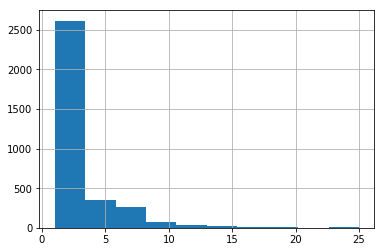

In [35]:

logical_index = [
    'chromosome_1', 'strand_1', 'position_1',
    'chromosome_2', 'strand_2', 'position_2',
    ]

data = breakpoint_data.groupby(logical_index + ['cluster_id'])[['num_reads', 'num_unique_reads']].sum().reset_index()

data['num_reads'].hist()


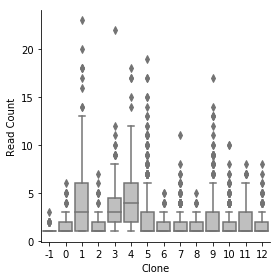

In [36]:

import seaborn

plot_data = data.rename(columns={
    'cluster_id': 'Clone',
    'num_unique_reads': 'Read Count',
})

seaborn.factorplot(y='Read Count', x='Clone', kind='box', data=plot_data, color='0.75', size=4)


   chromosome_1 strand_1  position_1 chromosome_2 strand_2  position_2  \
24            1        +    28145735            1        -    28139760   
25            1        +    28145735            1        -    28139760   
26            1        +    28145735            1        -    28139760   
27            1        +    28145735            1        -    28139760   
28            1        +    28145735            1        -    28139760   
29            1        +    28145735            1        -    28139760   
30            1        +    28145735            1        -    28139760   
31            1        +    28145735            1        -    28139760   
32            1        +    28145735            1        -    28139760   
33            1        +    28145735            1        -    28139760   
34            1        +    28145735            1        -    28139760   

    cluster_id  num_unique_reads  is_present  
24          -1               1.0           1  
25           0   

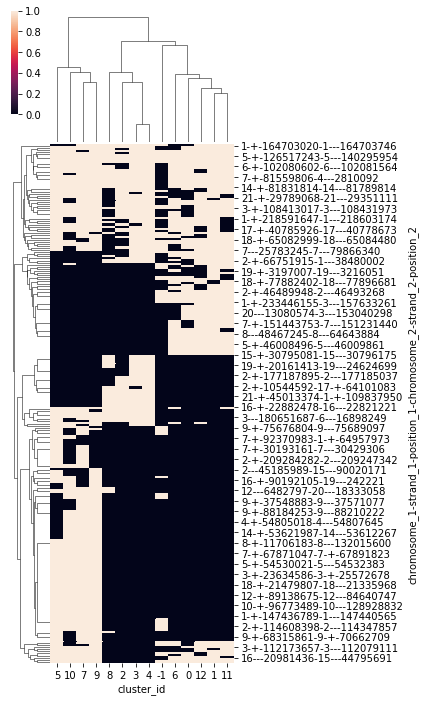

In [37]:

import seaborn
import sys
sys.setrecursionlimit(10000)

data2 = breakpoint_data.copy()

filtered = breakpoint_data.copy()
filtered = filtered[filtered['num_split'] > 4]
filtered = filtered[filtered['template_length_min'] > 250]
filtered = filtered[logical_index].drop_duplicates()

data2 = (
    data2.groupby(logical_index + ['cluster_id'])[['num_unique_reads']]
    .sum().unstack(fill_value=None).stack().reset_index())
data2['is_present'] = (data2['num_unique_reads'] > 0) * 1

print data2.query('position_1 == 28145735')

data2 = data2.merge(filtered)
data2 = data2.set_index(logical_index + ['cluster_id'])['is_present'].unstack(fill_value=None).fillna(0)

mask = data2.isnull()
g = seaborn.clustermap(data2, mask=mask, rasterized=True, figsize=(4, 12))


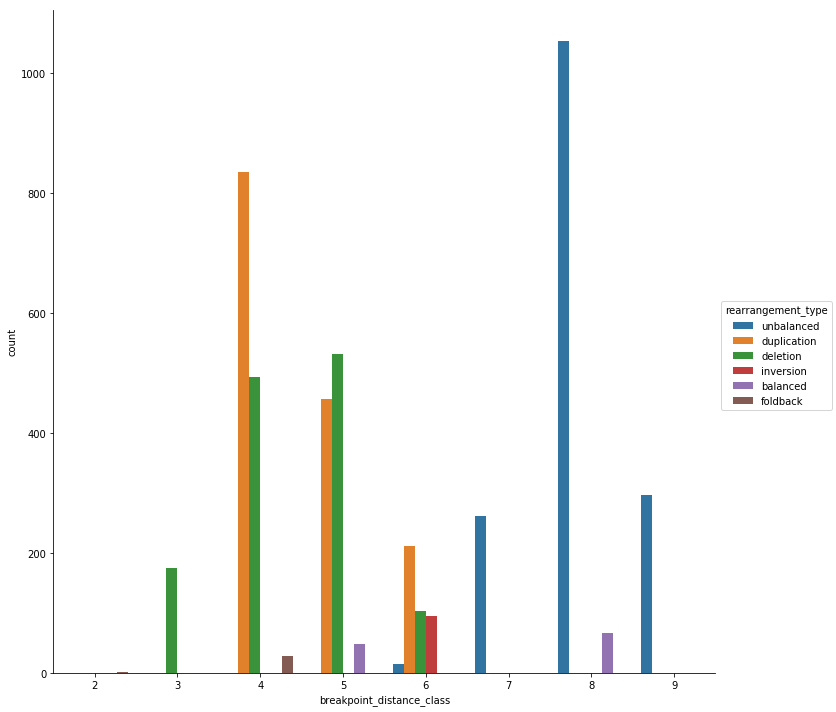

In [38]:

import numpy as np

filtered = breakpoint_data.copy()
filtered = filtered[filtered['num_split'] > 4]
filtered = filtered[filtered['template_length_min'] > 250]
filtered['breakpoint_distance'] = (filtered['position_1'] - filtered['position_2']).abs()
bins = np.logspace(0, np.log10(1e10), 11)
filtered['breakpoint_distance_class'] = np.digitize(filtered['breakpoint_distance'], bins)

seaborn.factorplot(hue='rearrangement_type', x='breakpoint_distance_class', data=filtered, kind='count', size=10)
